# To extract feature vector from galaxy image cutouts

I transfer galaxy images to data vectors using ResNet (https://arxiv.org/pdf/1512.03385.pdf) . While the predictions of object type are not expected to make sense for galaxy images (clocks?!), the model is able to diffrentiate between different features such as clumpiness, spiral arms, evolved bulge, etc. in image cutouts. The feature extraction is done on three color images so it has information about the SED shape. I next reduce dimensions of these vectors using UMAP, which can be used to define clustering and much more. 

In [1]:
from keras.preprocessing import image
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import h5py
import umap.umap_ as umap

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet')


Using TensorFlow backend.


In [2]:
hf = h5py.File('Sample_color.hdf5', 'r')
x_train,y_train = hf['train_img'], hf['train_labels']


%rm 'Sample_features.hdf5'
hdf5_file = h5py.File('Sample_features.hdf5', mode='w')
hdf5_file.create_dataset("feature_vectors", (len(x_train), 1000), np.float32)
hdf5_file.create_dataset("labels_vectors", (len(x_train), 6), np.float32)

for i in range(len(x_train)):
    
    if i % 500 == 0 and i > 1:
        print ('Train data: {}/{}'.format(i, len(x_train)))

    a = np.array(x_train[i,...])
    res = np.zeros((224,224,3))
    for ch in range(3):
        res[...,ch] = cv2.resize(a[...,ch], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    #plt.imshow(res[...,1])

    x = np.expand_dims(res, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    #print('Predicted:', decode_predictions(preds, top=3)[0])

    hdf5_file["feature_vectors"][i,...] = preds
    hdf5_file["labels_vectors"][i,...] = y_train[i,...]

hdf5_file.close()
hf.close()

Train data: 500/2321
Train data: 1000/2321
Train data: 1500/2321
Train data: 2000/2321


In [3]:
hf = h5py.File('Sample_features.hdf5', 'r')
features, labels = hf["feature_vectors"], hf["labels_vectors"]
print(features.shape)

hf2 = h5py.File('Sample_color.hdf5', 'r')
x_train = hf2['train_img']


(2321, 1000)


In [4]:
embedding = umap.UMAP(n_neighbors=20, min_dist=0.01,metric='braycurtis').fit_transform(features)


(-5.845075988769532, 4.87929859161377, -1.556523585319519, 5.518086338043213)

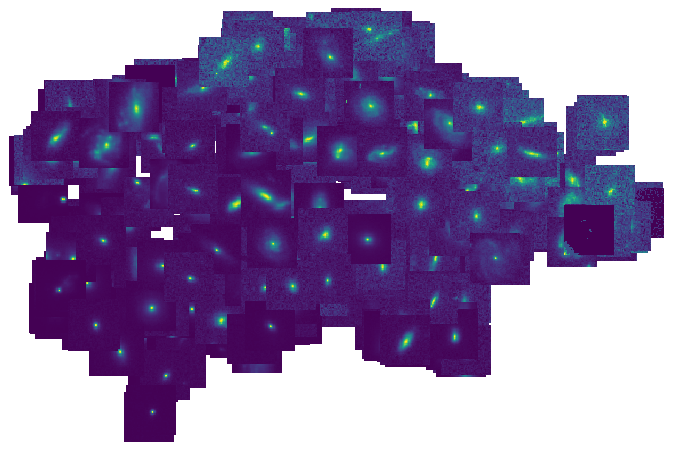

In [5]:
s = 0.4
list_of_corners,list_of_images = [],[]
for n in range(500):
    num = np.random.randint(len(x_train))
    x,y = embedding[num,0],embedding[num,1]
    list_of_corners.append((x-s, x+s, y-s, y+s))
    list_of_images.append(x_train[num,10:-10,10:-10,1])

fig, ax = plt.subplots(figsize=(12, 8))

for extent, img in zip(list_of_corners, list_of_images):
    plt.imshow(img, extent=extent)
ax.set_ylim([min(embedding[:,1])-s,max(embedding[:,1])+s])
ax.set_xlim([min(embedding[:,0])-s,max(embedding[:,0])+s])
ax.axis('off')
plt.savefig('galaxy_features.jpg',dpi=100)

In [6]:
## using the UVJ selection from Williams et al. to see if image features correlate with the uvj selection

U,V,J = labels[:,3], labels[:,4], labels[:,5]
uvj = np.ones_like(U) #starforming
for i in range(len(U)):
    if ((U[i] - V[i]) > 0.88*(V[i] -J[i]) + 0.59):
        uvj[i] = 0 #quiescent
        

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


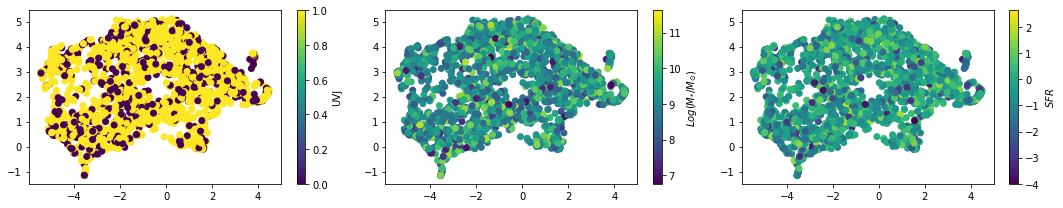

In [7]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
cf=plt.scatter(embedding[:,0],embedding[:,1],c=uvj)
plt.colorbar(label='UVJ')

plt.subplot(1,3,2)
cf=plt.scatter(embedding[:,0],embedding[:,1],c=np.log10(labels[:,1]))
plt.colorbar(label='$Log(M_{*}/M_{\odot})$')

plt.subplot(1,3,3)
cf=plt.scatter(embedding[:,0],embedding[:,1],c=np.log10(labels[:,2]))
plt.colorbar(label='$SFR$')
plt.tight_layout()